In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt

In [5]:
import statsmodels.api as sm

In [6]:

ts_BRENT = pd.read_excel('./Data para Proyecciones/BRENT_V2/BRENT.xlsx')
ts_BRENT.Añomes = pd.to_datetime(ts_BRENT.Añomes, format='%Y%m')
ts_BRENT.set_index('Añomes', inplace=True)

ts_BRENT = ts_BRENT['Brent'].round(3)
ts_BRENT.head()

Añomes
2010-01-01    479.094
2010-02-01    463.873
2010-03-01    495.825
2010-04-01    533.501
2010-05-01    477.710
Name: Brent, dtype: float64

In [7]:
err_lag1 = pd.concat([pd.Series(ts_BRENT, name='Y').iloc[1:], pd.Series(ts_BRENT.shift(), name='Y-1').iloc[1:]], axis=1)
err_lag1.corr()

,Y,Y-1
Y,1.000000,0.978748
Y-1,0.978748,1.000000


In [8]:
rw_errores = err_lag1.copy()

for k in range(2, 10):
    aux_lag = pd.Series(ts_BRENT.shift(k), name=f'Y-{k}')
    
    rw_errores = pd.concat([rw_errores, aux_lag], axis=1)
    
    
rw_errores = rw_errores.iloc[4:]

for k in range(1,10):
    rw_errores[f'e_{k}'] = rw_errores['Y'] - rw_errores[f'Y-{k}']
    
rw_errores.head()

,Y,Y-1,Y-2,Y-3,Y-4,Y-5,Y-6,Y-7,Y-8,Y-9,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9
Añomes,,,,,,,,,,,,,,,,,,,
2010-05-01,477.710,533.501,495.825,463.873,479.094,NaN,NaN,NaN,NaN,NaN,-55.791,-18.115,13.837,-1.384,NaN,NaN,NaN,NaN,NaN
2010-06-01,470.225,477.710,533.501,495.825,463.873,479.094,NaN,NaN,NaN,NaN,-7.485,-63.276,-25.600,6.352,-8.869,NaN,NaN,NaN,NaN
2010-07-01,475.383,470.225,477.710,533.501,495.825,463.873,479.094,NaN,NaN,NaN,5.158,-2.327,-58.118,-20.442,11.510,-3.711,NaN,NaN,NaN
2010-08-01,484.566,475.383,470.225,477.710,533.501,495.825,463.873,479.094,NaN,NaN,9.183,14.341,6.856,-48.935,-11.259,20.693,5.472,NaN,NaN
2010-09-01,489.598,484.566,475.383,470.225,477.710,533.501,495.825,463.873,479.094,NaN,5.032,14.215,19.373,11.888,-43.903,-6.227,25.725,10.504,NaN


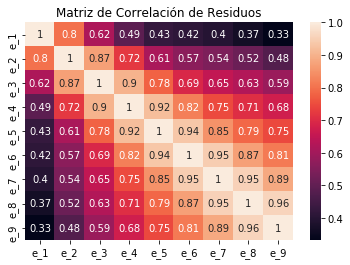

In [17]:
sns.heatmap(rw_errores[[col for col in rw_errores.columns if 'e_' in col]].corr(), annot=True)
plt.title('Matriz de Correlación de Residuos')
plt.show()

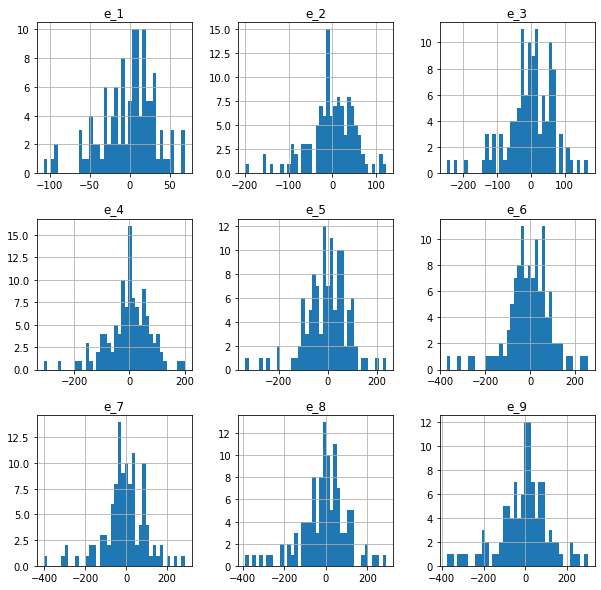

In [10]:
rw_errores[[col for col in rw_errores.columns if 'e_' in col]].hist(figsize=(10,10), bins=40)
plt.show()

In [11]:
pred_RW = pd.Series([rw_errores['Y'][-1]]*len(pd.date_range(start='2020-01-01', end='2026-01-01')), index=pd.date_range(start='2020-01-01', end='2026-01-01'),
                    name='prediccion')

In [12]:
def get_std_RW(t):
    return rw_errores['e_1'].std()*np.sqrt(t)

pred_RW_sigma1 = pd.Series([get_std_RW(t) for t in range(1, len(pred_RW)+1)], name='sigma1', index=pred_RW.index)
pred_RW = pd.concat([pred_RW, pred_RW_sigma1], axis=1)

In [13]:
pred_RW['sigma2'] = pred_RW.sigma1 * 2
pred_RW['sigma3'] = pred_RW.sigma1 * 3

pred_RW.head()

,prediccion,sigma1,sigma2,sigma3
2020-01-01,407.984,34.096543,68.193085,102.289628
2020-01-02,407.984,48.219793,96.439586,144.659379
2020-01-03,407.984,59.056944,118.113889,177.170833
2020-01-04,407.984,68.193085,136.386171,204.579256
2020-01-05,407.984,76.242187,152.484374,228.726562


In [14]:
pred_RW['pred_s1_ls'] = pred_RW.prediccion + pred_RW.sigma1
pred_RW['pred_s1_li'] = pred_RW.prediccion - pred_RW.sigma1
pred_RW['pred_s2_ls'] = pred_RW.prediccion + pred_RW.sigma2
pred_RW['pred_s2_li'] = pred_RW.prediccion - pred_RW.sigma2
pred_RW['pred_s3_ls'] = pred_RW.prediccion + pred_RW.sigma3
pred_RW['pred_s3_li'] = pred_RW.prediccion - pred_RW.sigma3

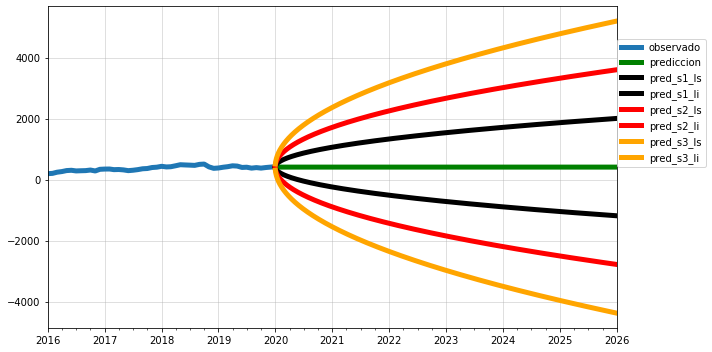

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
rw_errores.loc[rw_errores.index >= '2016-01-01', 'Y'].plot(ax=ax, lw=5, label='observado')
pred_RW[[col for col in pred_RW.columns if 'pred' in col]].plot(color=['green', 'black', 'black', 'red', 'red', 'orange', 'orange'],
                                                                lw=5, ax=ax)

# plt.ylim(0)
plt.legend(loc=(1,0.5))
plt.grid(True, alpha=0.5)
plt.tight_layout()

Se verifica que los intervalos divergen y por lo tanto es preciso recurrir al modelo de Mean Revertion

## Mean Revertion

In [34]:
rw_errores[['Y', 'Y-1']].corr()

,Y,Y-1
Y,1.000000,0.979164
Y-1,0.979164,1.000000


In [35]:
y_MR = rw_errores['e_1']

X_MR = rw_errores['Y-1']

X_MR = sm.add_constant(X_MR)

model = sm.OLS(y_MR, X_MR, hasconst=True)
results = model.fit()

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    e_1   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.066
Date:                Mon, 11 May 2020   Prob (F-statistic):              0.304
Time:                        00:12:56   Log-Likelihood:                -572.94
No. Observations:                 116   AIC:                             1150.
Df Residuals:                     114   BIC:                             1155.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7864     10.070      0.873      0.385     -11.162      28.735
Y-1           -0.0197      0.019     -1.032      0.304      -0.057       0.018
==============================================================================
Omnibus:                       10.149   Durbin-Watson:                   1.360
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.300
Skew:                          -0.634   Prob(JB):                      0.00580
Kurtosis:                       3.722   Cond. No.                     1.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
nu = -1 * np.log(1+results.params[1]) ## negativo del logaritmo natural del coeficiente de Y_t-1
desvest = results.resid.std()

p_final = rw_errores.Y[-1]
p_media = rw_errores.Y.mean()
t = range(len(pd.date_range(start='2019-01-01', end='2027-01-01', freq='MS')))

def get_esperanza_MR(t):
    return p_media + (p_final - p_media)*np.exp(-t*nu)

data={
    't':t,
    'E_Y': [get_esperanza_MR(t) for t in t]
}

pred_MR = pd.DataFrame(data=data, index=pd.date_range(start='2019-01-01', end='2027-01-01', freq='MS'))

def get_varianza_MR(t):
    return (((desvest**2)/2)*nu)*(1-np.exp(-2*nu*t))

pred_MR['std_Y'] = pred_MR.t.apply(get_varianza_MR).apply(np.sqrt)
pred_MR['sigma1_li'] = pred_MR.E_Y - pred_MR.std_Y
pred_MR['sigma1_ls'] = pred_MR.E_Y + pred_MR.std_Y

In [55]:
print(f'''
Parámetros
""""""""""

Nu = {nu :.4f}
Desvío Estándar de los Residuos = {desvest :.4f}
Último precio = {p_final:.4f}
Promedio precio = {p_media:.4f}
Desvío Estándar Precio = {desvest_precio:.4f}
      
      
''')


Parámetros
""""""""""

Nu = 0.0199
Desvío Estándar de los Residuos = 33.9383
Último precio = 407.9840
Promedio precio = 500.9444
Desvío Estándar Precio = 167.1268
      
      



In [56]:
pred_MR['sigma2_li'] = pred_MR.E_Y - 2 * pred_MR.std_Y
pred_MR['sigma2_ls'] = pred_MR.E_Y + 2 * pred_MR.std_Y

pred_MR['sigma3_li'] = pred_MR.E_Y - 3 * pred_MR.std_Y
pred_MR['sigma3_ls'] = pred_MR.E_Y + 3 * pred_MR.std_Y

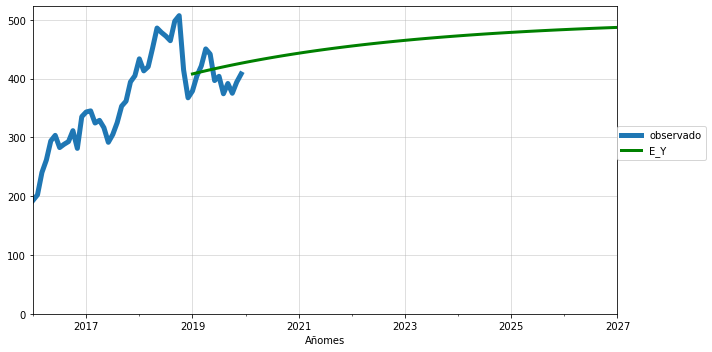

In [64]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
rw_errores.loc[rw_errores.index >= '2016-01-01', 'Y'].plot(ax=ax, lw=5, label='observado')
pred_MR.plot(y=['E_Y', 'sigma1_li', 'sigma1_ls', 'sigma2_li', 'sigma2_ls', 'sigma3_li', 'sigma3_ls'],
             color=['green', 'black', 'black', 'red', 'red', 'orange', 'orange'], lw=3, ax=ax)
plt.ylim(0)
plt.legend(loc=(1,0.5))
plt.grid(True, alpha=0.5)
plt.tight_layout()
# plt.savefig('./visuals/BRENT_paraLucas/proyeccionMR_Brent.jpg')

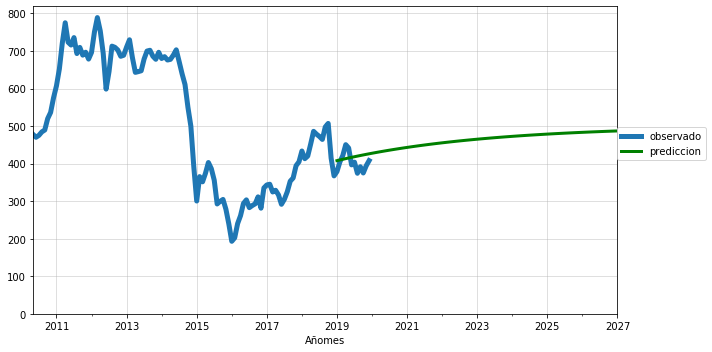

In [67]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
rw_errores.loc[rw_errores.index >= '2010-01-01', 'Y'].plot(ax=ax, lw=5, label='observado')
pred_MR.plot(y=['E_Y'],
             color=['green', 'black', 'black', 'red', 'red', 'orange', 'orange'], lw=3, ax=ax, label=['prediccion'])
plt.ylim(0)
plt.legend(loc=(1,0.5))
plt.grid(True, alpha=0.5)
plt.tight_layout()
# plt.savefig('./visuals/BRENT_paraLucas/proyeccionMR_Brent_3.jpg')

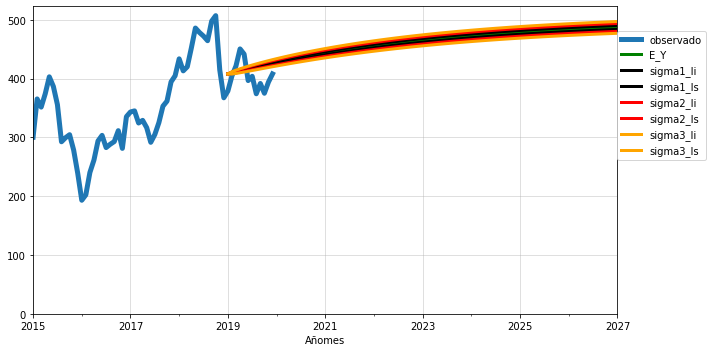

In [59]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
rw_errores.loc[rw_errores.index >= '2015-01-01', 'Y'].plot(ax=ax, lw=5, label='observado')
pred_MR.plot(y=['E_Y', 'sigma1_li', 'sigma1_ls', 'sigma2_li', 'sigma2_ls', 'sigma3_li', 'sigma3_ls'],
             color=['green', 'black', 'black', 'red', 'red', 'orange', 'orange'], lw=3, ax=ax)
plt.ylim(0)
plt.legend(loc=(1,0.5))
plt.grid(True, alpha=0.5)
plt.tight_layout()
# plt.savefig('./visuals/BRENT_paraLucas/proyeccionMR_Brent_3.jpg')

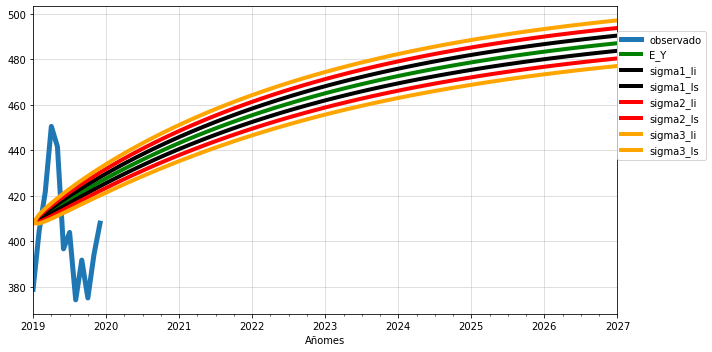

In [60]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
rw_errores.loc[rw_errores.index >= '2019-01-01', 'Y'].plot(ax=ax, lw=5, label='observado')
pred_MR.plot(y=['E_Y', 'sigma1_li', 'sigma1_ls', 'sigma2_li', 'sigma2_ls', 'sigma3_li', 'sigma3_ls'],
             color=['green', 'black', 'black', 'red', 'red', 'orange', 'orange'], lw=4, ax=ax)
# plt.ylim(0)
plt.legend(loc=(1,0.5))
plt.grid(True, alpha=0.5)
plt.tight_layout()
# plt.savefig('./visuals/BRENT_paraLucas/proyeccionMR_Brent_2.jpg')

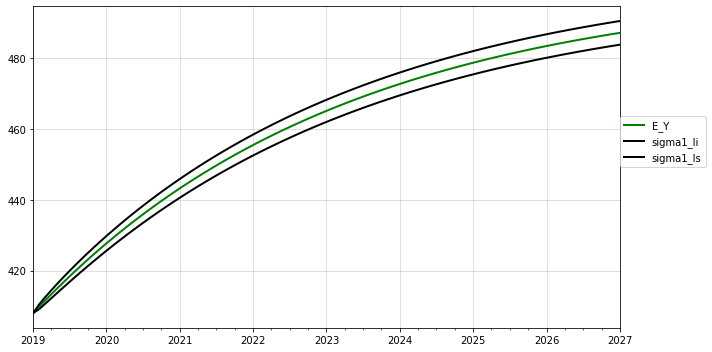

In [53]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
# rw_errores.loc[rw_errores.index >= '2016-01-01', 'Y'].plot(ax=ax, lw=5, label='observado')
pred_MR.plot(y=['E_Y', 'sigma1_li', 'sigma1_ls'], color=['green', 'black', 'black'], lw=2, ax=ax)
# plt.ylim(0)
plt.legend(loc=(1,0.5))
plt.grid(True, alpha=0.5)
plt.tight_layout()

# plt.savefig('./visuals/MR_BRENT_ARG_3.jpg')

In [61]:
pred_MR

,t,E_Y,std_Y,sigma1_li,sigma1_ls,sigma2_li,sigma2_ls,sigma3_li,sigma3_ls
2019-01-01,0,407.984000,0.000000,407.984000,407.984000,407.984000,407.984000,407.984000,407.984000
2019-02-01,1,409.811341,0.667142,409.144198,410.478483,408.477056,411.145625,407.809914,411.812767
2019-03-01,2,411.602761,0.934254,410.668506,412.537015,409.734252,413.471270,408.799997,414.405524
2019-04-01,3,413.358966,1.133107,412.225859,414.492074,411.092752,415.625181,409.959644,416.758289
2019-05-01,4,415.080650,1.295774,413.784876,416.376424,412.489102,417.672198,411.193328,418.967972
...,...,...,...,...,...,...,...,...,...
2026-09-01,92,485.979617,3.337229,482.642387,489.316846,479.305158,492.654075,475.967929,495.991304
2026-10-01,93,486.273783,3.338957,482.934826,489.612740,479.595869,492.951696,476.256912,496.290653
2026-11-01,94,486.562166,3.340616,483.221550,489.902783,479.880934,493.243399,476.540317,496.584016
2026-12-01,95,486.844881,3.342211,483.502671,490.187092,480.160460,493.529302,476.818250,496.871513


In [63]:
# pred_MR.to_excel('./Data para Proyecciones/BRENT_V2/PrediccionMeanRevertion.xlsx')